In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn

functions define

In [31]:
def get_data_dict(data):
    data_dict = {}
    for m in range(12):
        row = m*18*20
        temp = data.iloc[row:row+18]
        for d in range(1,20):
            row += 18
            temp = pd.concat([temp,data.iloc[row:row+18]],axis=1)
        temp.set_axis(range(24*20),axis=1,inplace=True)
        data_dict[m] = temp
    return data_dict

def getMonthTrainData(month,hours,features):
    label = month.loc['PM2.5',hours:]
    X = np.empty((480-hours,len(features)*hours))
    for i in range(480-hours):
        X[i,:] = month.loc[features,i:i+hours-1].values.flatten()
    return X,label.values.astype(np.float32)

def getYearTrainData(dict,hours,features):
    X,y = getMonthTrainData(dict[0],hours,features)
    for m in range(1,12):
        temp_X,temp_y = getMonthTrainData(dict[m],hours,features)
        X = np.concatenate((X,temp_X),axis=0)
        y = np.concatenate((y,temp_y),axis=0)
    return X,y.reshape(y.shape[0],-1)

def normal(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    return (X-mu)/sigma,mu,sigma


读取训练数据

In [32]:
data = pd.read_csv('train.csv',engine='python')

data.columns = ['Date', 'Place', 'Test', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23']

data.drop(['Date','Place'],axis='columns',inplace=True)

data.set_index('Test',inplace=True)

data[data=='NR'] = 0

data_dict = get_data_dict(data)

In [33]:
hours = 9
features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR']

In [46]:
X,y = getYearTrainData(data_dict,hours,features)

X = X.astype(np.float32)
y = y.astype(np.float32)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

X_train_norm = np.concatenate((np.ones((X_train_norm.shape[0],1),dtype=np.float32),X_train_norm),axis=1)
X_test_norm = np.concatenate((np.ones((X_test_norm.shape[0],1),dtype=np.float32),X_test_norm),axis=1)


In [47]:
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)

In [48]:
X_test_norm = torch.from_numpy(X_test_norm)
y_test = torch.from_numpy(y_test)

In [49]:
class linear_regression(nn.Module):
    def __init__(self,num_features):
        super(linear_regression,self).__init__()
        self.linear = nn.Linear(num_features,1)
    def forward(self,x):
        return self.linear(x)

In [82]:
epochs = 10000

loss_history = []

m,n = X_train_norm.shape
# theta = torch.zeros((n,1),dtype=torch.float64,requires_grad=True)
model = linear_regression(n)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train_norm)

    loss = loss_func(y_pred,y_train)
#     print(loss)
#     break
    loss.backward()
    optimizer.step()
    loss_history.append(loss)

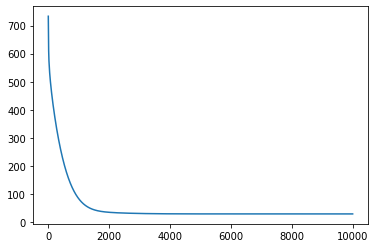

In [83]:
plt.plot(loss_history)

In [84]:
y_pred[:5],y_train[:5]

(tensor([[16.8975],
         [23.8551],
         [69.8650],
         [26.7569],
         [22.8588]], grad_fn=<SliceBackward>),
 tensor([[20.],
         [22.],
         [66.],
         [20.],
         [27.]]))

In [85]:
y_pred.shape

torch.Size([3786, 1])

In [86]:
loss

tensor(29.6172, grad_fn=<MseLossBackward>)

In [87]:
model.eval()
loss_func(model(X_test_norm),y_test)

tensor(39.8047, grad_fn=<MseLossBackward>)